In [ ]:
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate

!pip install datasets
!pip install ml_things

!pip install bitsandbytes

import transformers
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import numpy as np
from ml_things import plot_dict

from transformers import (TrainingArguments,
                          Trainer,
                          AutoTokenizer, 
                          GPTJForCausalLM)

from bitsandbytes.functional import quantize_blockwise, dequantize_blockwise
from collections import OrderedDict

# for graphing
import seaborn as sns
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-4rbelf0y
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-4rbelf0y
  Resolved https://github.com/huggingface/transformers to commit 0558914dff91963f0488bd28747cdd45e933e7a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 72.0 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.28.0.dev0-py3-none-any.whl size=6758777 sha256=7b5f73daff54ea473d9584f4c9ad8fe1c111d7cbc8c59c11e4f4f85e108ee353
  Stored in directory: /tmp/pip-ephem-wheel-cache-rt4njckh/wheels/14/a0/7b/8f6b25ba4110aa215fcb8d6aedd6cd4f9b9b6619190

In [ ]:
# klue/ynat 데이터 불러오기
from datasets import load_dataset

dataset = load_dataset("klue", "ynat")

Generating train split:   0%|          | 0/45678 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9107 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/ynat/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# argment setting
model_checkpoint = "kakaobrain/kogpt"
batch_size_per_device = 32
max_length = 64
n_epochs = 2
warmup_ratio = .2
lr = 5e-5

In [ ]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')
    
# klue/ynat 라벨 설정
labels_ids = {0:'IT과학', 1:'경제', 2:'사회', 3:'생활문화', 4:'세계', 5:'스포츠', 6:'정치'}

# 라벨 크기 설정.
n_labels = len(labels_ids)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


In [ ]:
# Get model's tokenizer.
tokenizer = AutoTokenizer.from_pretrained(
  model_checkpoint, revision='KoGPT6B-ryan1.5b-float16',  # or float32 version: revision=KoGPT6B-ryan1.5b
  bos_token='[BOS]', eos_token='[EOS]', unk_token='[UNK]', pad_token='[PAD]', mask_token='[MASK]'
)

In [ ]:
from typing import Tuple
from torch.cuda.amp import custom_fwd, custom_bwd

class DequantizeAndLinear(torch.autograd.Function):
    @staticmethod
    @custom_fwd
    def forward(ctx, input: torch.Tensor, weights_quantized: torch.ByteTensor,
                absmax: torch.FloatTensor, code: torch.FloatTensor, bias: torch.FloatTensor):
        
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        ctx.save_for_backward(input, weights_quantized, absmax, code)
        ctx._has_bias = bias is not None
        return F.linear(input, weights_deq, bias)
    
    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output: torch.Tensor):
        assert not ctx.needs_input_grad[1] and not ctx.needs_input_grad[2] and not ctx.needs_input_grad[3]
        input, weights_quantized, absmax, code = ctx.saved_tensors
        # grad_output: [*batch, out_features]
        weights_deq = dequantize_blockwise(weights_quantized, absmax=absmax, code=code)
        grad_input = grad_output @ weights_deq
        grad_bias = grad_output.flatten(0, -2).sum(dim=0) if ctx._has_bias else None
        return grad_input, None, None, None, grad_bias


class BNBLinearWithAdapter(nn.Module):
    def __init__(self, weight, absmax, code,  bias=None, adapter_dim=0):
        assert isinstance(bias, nn.Parameter) or bias is None
        super().__init__()
        self.out_features, self.in_features = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        self.bias = bias
        
        if adapter_dim > 0:
            self.adapter = nn.Sequential(
                nn.Linear(self.in_features, adapter_dim, bias=False),
                nn.Linear(adapter_dim, self.out_features, bias=False),
            )
            
            nn.init.zeros_(self.adapter[1].weight)
        else:
            self.adapter = None
        
    def forward(self, input):
        out = DequantizeAndLinear.apply(input, self.weight, self.absmax, self.code, self.bias)
        
        if self.adapter:
            return self.adapter(input) + out
            
        return out
        
    
    @classmethod
    def from_linear(cls, linear: nn.Linear, **kwargs) -> "FrozenBNBLinear":
        weights_int8, state = quantize_blockise_lowmemory(linear.weight)
        return cls(weights_int8, *state, linear.bias, **kwargs)
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_features}, {self.out_features})"

class BNBEmbeddingWithAdapter(nn.Module):
    def __init__(self, weight, absmax, code, adapter_dim=0):
        super().__init__()
        self.num_embeddings, self.embedding_dim = weight.shape
        self.register_buffer("weight", weight.requires_grad_(False))
        self.register_buffer("absmax", absmax.requires_grad_(False))
        self.register_buffer("code", code.requires_grad_(False))
        
        if adapter_dim > 0:
            self.adapter = nn.Sequential(
                nn.Embedding(self.num_embeddings, adapter_dim),
                nn.Linear(adapter_dim, self.embedding_dim, bias=False),
            )
            
            nn.init.zeros_(self.adapter[1].weight)
        else:
            self.adapter = None
        
    def forward(self, input, **kwargs):
        with torch.no_grad():
            # note: both quantuized weights and input indices are *not* differentiable
            weight_deq = dequantize_blockwise(self.weight, absmax=self.absmax, code=self.code)
            out = F.embedding(input, weight_deq, **kwargs)
        if self.adapter:
            return out + self.adapter(input, **kwargs)
        
        return out
    
    @classmethod
    def from_embedding(cls, embedding: nn.Embedding, **kwargs) -> "FrozenBNBEmbedding":
        weights_int8, state = quantize_blockise_lowmemory(embedding.weight)
        return cls(weights_int8, *state, **kwargs)
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.num_embeddings}, {self.embedding_dim})"

In [ ]:
def quantize_blockise_lowmemory(matrix: torch.Tensor, chunk_size: int = 2 ** 20):
    assert chunk_size % 4096 == 0
    code = None
    chunks = []
    absmaxes = []
    flat_tensor = matrix.reshape(-1)
    for i in range((matrix.numel() - 1) // chunk_size + 1):
        input_chunk = flat_tensor[i * chunk_size: (i + 1) * chunk_size].clone()
        quantized_chunk, (absmax_chunk, code) = quantize_blockwise(input_chunk, code=code)
        chunks.append(quantized_chunk)
        absmaxes.append(absmax_chunk)
        
    matrix_i8 = torch.cat(chunks).reshape_as(matrix)
    absmax = torch.cat(absmaxes)
    return matrix_i8, (absmax, code)

In [ ]:
def bnbfy_(model, adapter_dim: int = 0):
    for module in list(model.modules()):
        for name, child in module.named_children():
            if isinstance(child, nn.Linear):
                print(name, child)
                setattr(module, name, BNBLinearWithAdapter.from_linear(child, adapter_dim=adapter_dim))
                
            elif isinstance(child, nn.Embedding):
                print(name, child)
                setattr(module, name, BNBEmbeddingWithAdapter.from_embedding(child, adapter_dim=adapter_dim))

In [ ]:
from accelerate import init_empty_weights
from transformers import AutoConfig, AutoModelForCausalLM

print('Loading model...')
model = GPTJForCausalLM.from_pretrained(model_checkpoint, revision='KoGPT6B-ryan1.5b-float16', torch_dtype='auto', low_cpu_mem_usage=True)
model.resize_token_embeddings(len(tokenizer))

Loading model...


Embedding(63998, 4096)

In [ ]:
bnbfy_(model, adapter_dim=16)

lm_head Linear(in_features=4096, out_features=63998, bias=True)
wte Embedding(63998, 4096)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features=4096, out_features=4096, bias=False)
out_proj Linear(in_features=4096, out_features=4096, bias=False)
fc_in Linear(in_features=4096, out_features=16384, bias=True)
fc_out Linear(in_features=16384, out_features=4096, bias=True)
k_proj Linear(in_features=4096, out_features=4096, bias=False)
v_proj Linear(in_features=4096, out_features=4096, bias=False)
q_proj Linear(in_features

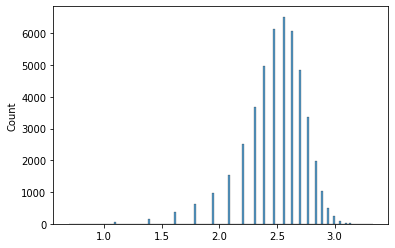

log value : 3.291528823897666
original value : 26.883933053276284


In [ ]:
# 훈련 데이터 시각화
tokenizer_len = [len(tokenizer(s)['input_ids']) for s in dataset['train']['title']]
sns.histplot(tokenizer_len)
plt.show()

print(f"mean length : {np.mean(tokenizer_len)}")
print(f"min length : {np.min(tokenizer_len)}")
print(f"max length : {np.max(tokenizer_len)}")

In [ ]:
# 토큰 정보 출력 
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1000000000000000019884624838656 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token [BOS] token has the id 0
The end of sequence token [EOS] has the id 1
The padding token [PAD] has the id 3


In [ ]:
# Dataset class
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
  def __init__(self, txt_list, label_list, tokenizer, max_length):
    # define variables
    self.input_ids = []
    self.attn_masks = []
    self.labels = []
    map_label = {0:'IT과학', 1:'경제', 2:'사회', 3:'생활문화', 4:'세계', 5:'스포츠', 6:'정치'}

    # iterate through the dataset
    for txt, label in zip(txt_list, label_list):
      
      # prepare the text
      prep_txt = f'[BOS]텍스트: {txt}\n주제: {map_label[label]}[EOS]'

      # tokenize
      encodings_dict = tokenizer(prep_txt, truncation=True, max_length=max_length, padding="max_length")

      # append to list
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
      self.labels.append(map_label[label])
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx], self.labels[idx]

In [ ]:
def load_dataset(tokenizer):
  train_dataset = ClassificationDataset(dataset['train']['title'], dataset['train']['label'], tokenizer, max_length = max_length)
  valid_dataset = ClassificationDataset(dataset['validation']['title'], dataset['validation']['label'], tokenizer, max_length = max_length)

  return train_dataset, valid_dataset

In [ ]:
len_dataset = len(dataset['train'])
len_validset = len(dataset['validation'])

print('#train =', len_dataset,
      '#valid =', len_validset
      )

total_batch_size = batch_size_per_device * torch.cuda.device_count()
n_total_iterations = int(len_dataset / total_batch_size * n_epochs)
n_warmup_steps = int(n_total_iterations * warmup_ratio)

print(
        '#total_iters =', n_total_iterations,
        '#warmup_iters =', n_warmup_steps,
      )

#train = 45678 #valid = 9107
#total_iters = 2854 #warmup_iters = 570


In [ ]:
## Load model and data

# seed
torch.manual_seed(42)
model.resize_token_embeddings(len(tokenizer))

BNBEmbeddingWithAdapter(63998, 4096)

In [ ]:
model.cuda()

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): BNBEmbeddingWithAdapter(63998, 4096)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): BNBLinearWithAdapter(4096, 4096)
          (v_proj): BNBLinearWithAdapter(4096, 4096)
          (q_proj): BNBLinearWithAdapter(4096, 4096)
          (out_proj): BNBLinearWithAdapter(4096, 4096)
        )
        (mlp): GPTJMLP(
          (fc_in): BNBLinearWithAdapter(4096, 16384)
          (fc_out): BNBLinearWithAdapter(16384, 4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropou

In [ ]:
train_dataset, valid_dataset = load_dataset(tokenizer)

In [ ]:
train_dataset[0]

(tensor([    0, 22179,   132,  7453, 18881,   479,   530,   841, 25685,  1471,
          2242,  1618, 63997, 10886,   132,  1905,  1870,     1,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 '생활문화')

In [ ]:
## Train
training_args = TrainingArguments(
    output_dir = 'results',
    num_train_epochs = n_epochs,
    logging_steps = 10,
    load_best_model_at_end = True,
    save_strategy = "epoch",
    evaluation_strategy = "epoch",
    per_device_train_batch_size = batch_size_per_device,
    per_device_eval_batch_size = batch_size_per_device,
    warmup_steps = n_warmup_steps,
    weight_decay = 0.01,
    logging_dir = 'logs'
)

In [ ]:
## Start training
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,
    data_collator = lambda data: {'input_ids' : torch.stack([f[0] for f in data]),
                                  'attention_mask' : torch.stack([f[1] for f in data]),
                                  'labels' : torch.stack([f[0] for f in data])}
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.650000,0.902241
2,0.600500,0.921896


TrainOutput(global_step=2856, training_loss=1.073283914507938, metrics={'train_runtime': 9947.301, 'train_samples_per_second': 9.184, 'train_steps_per_second': 0.287, 'total_flos': 1229936147573760.0, 'train_loss': 1.073283914507938, 'epoch': 2.0})

In [ ]:
def sample(n):
  data = {
      'title':dataset['validation']['title'],
      'label':dataset['validation']['label']
  }
  return pd.DataFrame(data).sample(n)

#test = sample(100)
test = {
      'title':dataset['validation']['title'],
      'label':dataset['validation']['label']
  }

In [ ]:
import re
## Test

# set the model to eval mode
model.eval()

# run model inference on all test data
original_label, predicted_label, original_text, predicted_text = [], [], [], []

map_label = {0:'IT과학', 1:'경제', 2:'사회', 3:'생활문화', 4:'세계', 5:'스포츠', 6:'정치'}

# iter over all test data
for text, label in tqdm(zip(dataset['validation']['title'], dataset['validation']['label'])):
  # create prompt (int compliance with the one used during training)
  prompt = f'[BOS]텍스트: {text}\n주제:'

  # generate tokens
  generated = tokenizer(f'{prompt}', return_tensors='pt').input_ids.cuda()

  # perform prediction
  sample_outputs = model.generate(generated, do_sample=False, top_k = 50, max_length = max_length, top_p = 0.90,
                                  temperature=0, num_return_sequences=0,
                                  pad_token_id=tokenizer.pad_token_id,
                                  eos_token_id=tokenizer.eos_token_id,
                                  bos_token_id=tokenizer.bos_token_id, 
                                  use_cache=True)
  
  # decode the predicted tokens into texts
  pred_text = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)

  # extract the predicted label
  try:
    pred_label = re.findall('\n주제: (.*)', pred_text)[-1]
  except:
    pred_label = "None"

  # append results
  original_label.append(map_label[label])
  predicted_label.append(pred_label)
  original_text.append(text)
  predicted_text.append(pred_text)

# transform result into dataframe
df = pd.DataFrame({'original_text' : original_text,
                   'predicted_label' : predicted_label,
                   'original_label' : original_label,
                   'predicted_text' : predicted_text})

9107it [34:09,  4.44it/s]


In [ ]:
df

,original_text,predicted_label,original_label,predicted_text
0,5억원 무이자 융자는 되고 7천만원 이사비는 안된다,사회,사회,텍스트: 5억원 무이자 융자는 되고 7천만원 이사비는 안된다\n주제: 사회
1,왜 수소충전소만 더 멀리 떨어져야 하나 한경연 규제개혁 건의,사회,사회,텍스트: 왜 수소충전소만 더 멀리 떨어져야 하나 한경연 규제개혁 건의\n주제: 사회
2,항응고제 성분 코로나19에 효과…세포실험서 확인,IT과학,IT과학,텍스트: 항응고제 성분 코로나19에 효과…세포실험서 확인\n주제: IT과학
3,실거래가 가장 비싼 역세권은 신반포역…3.3㎡당 1억 육박,경제,경제,텍스트: 실거래가 가장 비싼 역세권은 신반포역…3.3㎡당 1억 육박\n주제: 경제
4,기자회견 하는 성 소수자 단체,사회,사회,텍스트: 기자회견 하는 성 소수자 단체\n주제: 사회
...,...,...,...,...
9102,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,경제,경제,텍스트: KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략\n주제: 경제
9103,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,사회,사회,텍스트: 1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토\n주제: 사회
9104,게시판 키움증권 2020 키움 영웅전 실전투자대회,경제,경제,텍스트: 게시판 키움증권 2020 키움 영웅전 실전투자대회\n주제: 경제
9105,답변하는 배기동 국립중앙박물관장,사회,사회,텍스트: 답변하는 배기동 국립중앙박물관장\n주제: 사회


In [ ]:
from sklearn.metrics import f1_score
result = f1_score(df['original_label'], df['predicted_label'], average = 'macro')

In [ ]:
# f1 score
result

0.8668622131702634

In [ ]:
model.eval()
prompt = '텍스트: 게시판 키움증권 2020 키움 영웅전 실전투자대회.\n주제:'
with torch.no_grad():
  tokens = tokenizer.encode(prompt, return_tensors='pt').to(device='cuda', non_blocking=True)
  gen_tokens = model.generate(tokens, do_sample=True, temperature=0.8, max_length=max_length,
                              pad_token_id=tokenizer.pad_token_id,
                              eos_token_id=tokenizer.eos_token_id,
                              bos_token_id=tokenizer.bos_token_id, 
                              use_cache=True)
  generated = tokenizer.batch_decode(gen_tokens)[0]
  
print(generated)

텍스트: 게시판 키움증권 2020 키움 영웅전 실전투자대회.
주제: 경제[EOS]


In [ ]:
def save_adapter(model, filepath):
  old_dict = model.state_dict()
  new_dict = OrderedDict()
  for key, val in old_dict.items():
    if 'adapter' in key:
      new_dict[key] = val
  
  torch.save(new_dict, filepath)

In [ ]:
def save_adapter(model, filepath):
  old_dict = model.state_dict()
  new_dict = OrderedDict()
  for key, val in old_dict.items():
    if 'adapter' in key:
      new_dict[key] = val
  
  torch.save(new_dict, filepath)

In [ ]:
# model weight 저장
filepath = '/content/model.pth'
save_adapter(model, filepath)